In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from ETL import ETL_Techniques 
from decompose import calibration
from time import time

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
print(PATH)

ROOT = os.path.join(PATH, "data/sample_particles_v2/")
print(ROOT)

/Users/javigamero/MyMac/DS_Master/TFM
/Users/javigamero/MyMac/DS_Master/TFM/data/sample_particles_v2/


In [3]:
################################################################################
# electron signals
################################################################################
# electron signals
DATA = os.path.join(PATH, 'data_preproc/')

e_signals = pd.read_csv(os.path.join(DATA, 'LightSignal_decomp_e.csv'), 
                        sep=';', index_col=0)

t = pd.read_csv(os.path.join(DATA, 'LightSignal_t.csv'), sep=';', index_col=0, 
                header=None)

t = np.array(t.iloc[0]).reshape(-1)

In [4]:
# max_p = 50 # number of photons
# t0 = 150 # ns

# criterias = []
# for index in e_signals.index: 
#     max_idx = np.argmax(e_signals.loc[index, :])
#     max_peak = np.max(e_signals.loc[index, :])
    
#     if max_peak > max_p and t[max_idx]>t0: 
#         criterias.append(index)

# e_signals = e_signals.loc[criterias,:]
# e_signals.shape

In [5]:
################################################################################
# General variables
################################################################################
# branches in the trees
branches_to_activate = ["stepX", "dE", "PDGcode", "eventID", "E", 
                        "energydepX", 'energydep']

# PMTs ids
PMTs = np.loadtxt(os.path.join(PATH, "data/PMT_IDs.txt"))
IdPMTs_L = [int(i) for i in PMTs if (i%2 == 0)] # even PMT IDs, left (X<0)
IdPMTs_R = [int(i) for i in PMTs if (i%2 != 0)] # odd PMT IDs, right (X>0)

# time of the ideal signal
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')

t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsense, remove it
t.set_index(0, inplace=True) # remove first time

t = np.array(t).reshape(-1).astype(np.int32)
t = t-5 # move to the edges of the bins to integrate

In [6]:
################################################################################
# MAIN LOOP
################################################################################
skip = os.path.join(ROOT, ".DS_Store/")

idx, energydepX, dE = [], [], []
m0 = time()

etl = ETL_Techniques(IdPMTs_L, IdPMTs_R)

ntree = 0
for folder in os.listdir(ROOT): 
    rel_PATH = os.path.join(ROOT, folder)
    rel_PATH += "/"
    
    if (rel_PATH == skip): continue # skip .DS_Store/ mac directory
    
    for f in os.listdir(rel_PATH):
        file = os.path.join(rel_PATH, f) # root file
        mi = time()
        
        # open trees file:
        with uproot.open(file) as rootfile: 
            
            tree = rootfile["opanatree/OpAnaTree"]
            branches = tree.arrays(branches_to_activate, library="np") 
            
            for entry in range(len(branches["eventID"])): # entries loop

                # in the decay of the muon, there are more particles apart of 
                # the Michel electron, dismiss the rest
                
                # dE_e, _, _, energydepX_e = etl.getElectron2EnergiesX0AndEnergydepx(
                #                                         branches["stepX"][entry], 
                #                                         branches["PDGcode"][entry],
                #                                         branches["dE"][entry],
                #                                         branches["E"][entry], 
                #                                         branches["energydepX"][entry]
                #                                         )
                
                dE_e, _ = etl.getElectronEnergyAndX0(branches["stepX"][entry],
                                                     branches["PDGcode"][entry],
                                                     branches["dE"][entry])
                
                energydep_e, energydepX_e = etl.getEnergyDepAndX(branches["PDGcode"][entry],
                                                                 branches["energydep"][entry],
                                                                 branches["energydepX"][entry],)
                
                idx.append(str(ntree)+'_'+str(entry+1))
                dE.append(dE_e) # MeV
                
                if len(energydepX_e)>0: 
                    # energydepX.append(np.abs(np.mean(energydepX_e)))
                    weighted_mean = np.abs(np.average(energydepX_e, 
                                                      weights=energydep_e))
                    
                    energydepX.append(weighted_mean)
                else: 
                    energydepX.append(0)
                
            
        # finish of file
        print(f'Time spent with tree {ntree}: {time()-mi} (s).')
        # print(np.shape(list_dE), np.shape(list_integrate))
        ntree+=1
        
print(f'Total time processing data: {(time()-m0)/60}(min).')

dE=pd.Series(dE, index=idx)
energydepX=pd.Series(energydepX, index=idx)

Time spent with tree 0: 0.08550024032592773 (s).
Time spent with tree 1: 0.08318710327148438 (s).
Time spent with tree 2: 0.08569478988647461 (s).
Time spent with tree 3: 0.08279919624328613 (s).
Time spent with tree 4: 0.08860015869140625 (s).
Time spent with tree 5: 0.08920788764953613 (s).
Time spent with tree 6: 0.08157181739807129 (s).
Time spent with tree 7: 0.07894706726074219 (s).
Time spent with tree 8: 0.08117985725402832 (s).
Time spent with tree 9: 0.08187985420227051 (s).
Time spent with tree 10: 0.08205795288085938 (s).
Time spent with tree 11: 0.09373331069946289 (s).
Time spent with tree 12: 0.12347793579101562 (s).
Time spent with tree 13: 0.07246899604797363 (s).
Time spent with tree 14: 0.07578086853027344 (s).
Time spent with tree 15: 0.07627606391906738 (s).
Time spent with tree 16: 0.07989811897277832 (s).
Time spent with tree 17: 0.07686686515808105 (s).
Time spent with tree 18: 0.07650995254516602 (s).
Time spent with tree 19: 0.0772237777709961 (s).
Time spent 

In [7]:
dE = np.array(dE.loc[e_signals.index]).reshape(-1)
energydepX = np.array(energydepX.loc[e_signals.index]).reshape(-1)

In [8]:
integral_signal = []
for i in range(energydepX.shape[0]):
    integral_signal.append(np.trapz(e_signals.iloc[i,:], t))

integral_signal = np.array(integral_signal).reshape(-1)

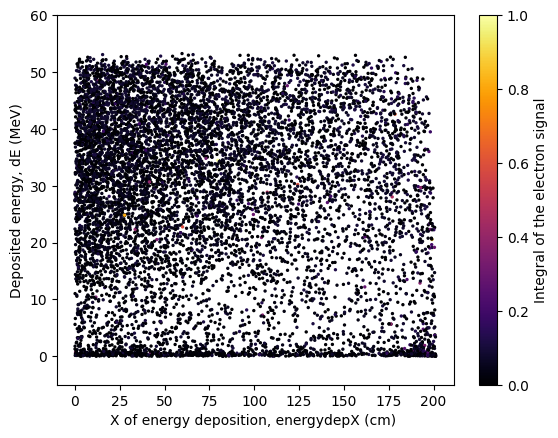

In [9]:
# f = np.where((integral_signal<20000) & (dE>1))
f = np.where(energydepX>0)


x = np.array(energydepX)[f]
y = np.array(dE)[f]
z = np.array(integral_signal)[f]

z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

plt.scatter(x, y, c=z_normalized, cmap=colormap, s=2, marker='o')

cbar = plt.colorbar()
cbar.set_label('Integral of the electron signal') 

plt.ylim(-5,60)
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.ylabel('Deposited energy, dE (MeV)')
plt.show()

[20, 11]


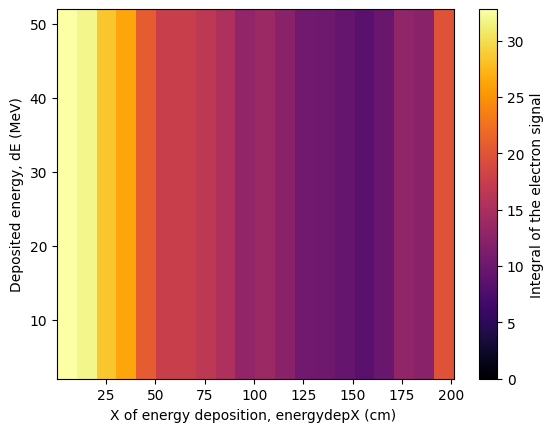

In [10]:
# f = np.where((integral_signal<20000) & (dE>1) & (dE<56))
f = np.where(energydepX>0)

x = np.array(energydepX)[f]
y = np.array(dE)[f]
z = np.array(integral_signal)[f]
z_normalized = (z - min(z)) / (max(z) - min(z))

bins = [20, 11] # bins --> (width 10cm in dEX, X) and (width = 5MeV in dE, Y)
print(bins)
plt.hist2d(x, y, weights=z_normalized, bins=bins, cmap=colormap)
cbar = plt.colorbar()
cbar.set_label('Integral of the electron signal') 

plt.ylim(2,52)
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.ylabel('Deposited energy, dE (MeV)')
plt.show()

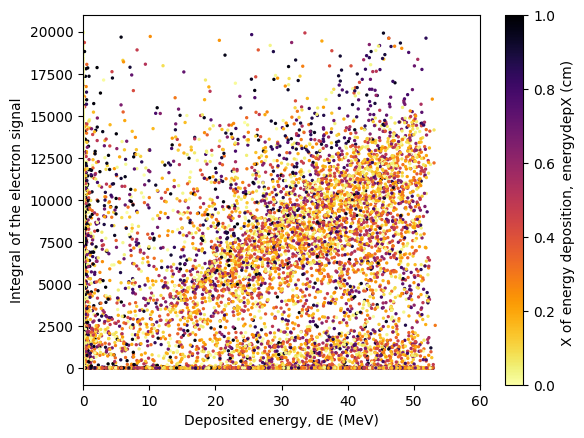

In [11]:
f = np.where(integral_signal<20000)

x = np.array(dE)[f]
y = np.array(integral_signal)[f]
z = np.array(energydepX)[f]

# X, Y = np.meshgrid(x,y)
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno_r')

plt.scatter(x, y, c=z_normalized, cmap=colormap, s=2, marker='o',
            vmin=0., vmax=1.)
cbar = plt.colorbar()
cbar.set_label('X of energy deposition, energydepX (cm) ') 
plt.ylabel('Integral of the electron signal')
plt.xlabel('Deposited energy, dE (MeV)')
plt.xlim(0,60)
plt.show()

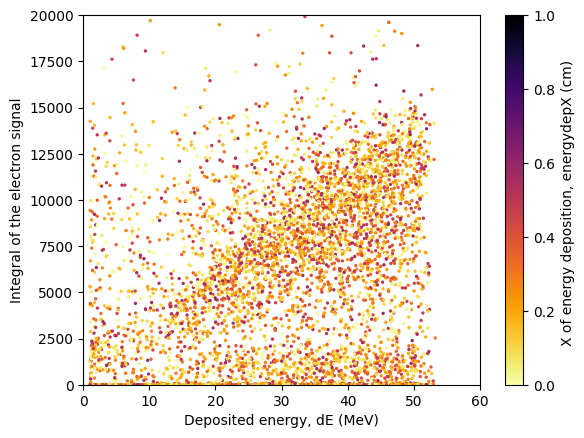

In [12]:
f = np.where((integral_signal<20000))

x = np.array(dE)[f]
y = np.array(integral_signal)[f]
z = np.array(energydepX)[f]

# X, Y = np.meshgrid(x,y)
z_normalized = (z - min(z)) / (max(z) - min(z))
f = np.where((z_normalized<0.6) & (x>1))

colormap = plt.get_cmap('inferno_r')

plt.scatter(x[f], y[f], c=z_normalized[f], cmap=colormap, s=2, marker='o', 
            vmin=0., vmax=1.)
cbar = plt.colorbar()
cbar.set_label('X of energy deposition, energydepX (cm) ') 
plt.ylabel('Integral of the electron signal')
plt.xlabel('Deposited energy, dE (MeV)')
plt.xlim(0,60)
plt.ylim(0,20000)
plt.show()

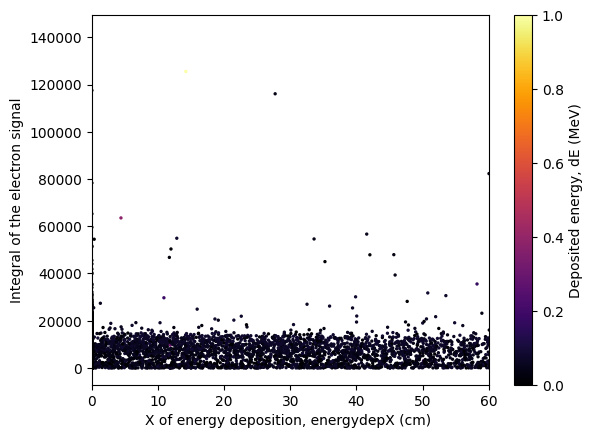

In [13]:
f = np.where((integral_signal>0))

x = np.array(energydepX)[f]
y = np.array(integral_signal)[f]
z = np.array(dE)[f]

# X, Y = np.meshgrid(x,y)
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

plt.scatter(x, y, c=z_normalized, cmap=colormap, s=2, marker='o',
            vmin=0., vmax=1.)
cbar = plt.colorbar()
cbar.set_label('Deposited energy, dE (MeV)') 
plt.ylabel('Integral of the electron signal')
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.xlim(0,60)
plt.show()

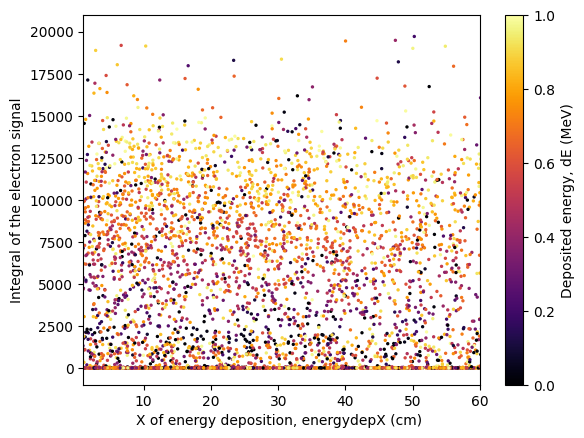

In [14]:
f = np.where((integral_signal<20000) & (dE<50))

x = np.array(energydepX)[f]
y = np.array(integral_signal)[f]
z = np.array(dE)[f]

# X, Y = np.meshgrid(x,y)
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

plt.scatter(x, y, c=z_normalized, cmap=colormap, s=2, marker='o')
cbar = plt.colorbar()
cbar.set_label('Deposited energy, dE (MeV)') 
plt.ylabel('Integral of the electron signal')
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.xlim(1,60)
plt.show()

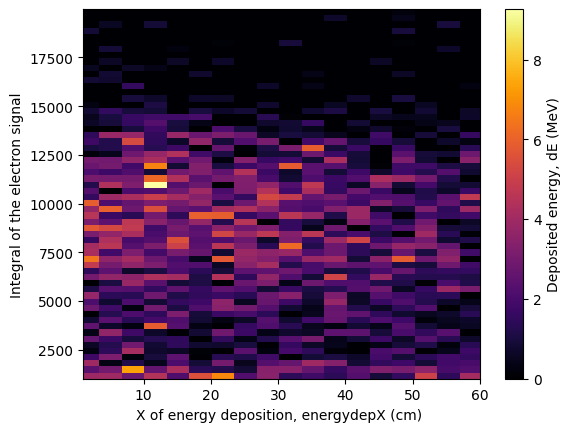

In [15]:
f = np.where((integral_signal<20000) & (integral_signal>1000) & (dE<50))

x = np.array(energydepX)[f]
y = np.array(integral_signal)[f]
z = np.array(dE)[f]

# X, Y = np.meshgrid(x,y)
z_normalized = (z - min(z)) / (max(z) - min(z))

colormap = plt.get_cmap('inferno')

plt.hist2d(x, y, weights=z_normalized, bins=60, cmap=colormap)
cbar = plt.colorbar()
cbar.set_label('Deposited energy, dE (MeV)') 
plt.ylabel('Integral of the electron signal')
plt.xlabel('X of energy deposition, energydepX (cm) ')
plt.xlim(1,60)
plt.show()